> **DEPRECATED:** This task is outdated and may not reflect current best practices.
> See `causalab/tasks/MCQA/` for an up-to-date example.

# IOI (Indirect Object Identification) Task Demo

This notebook demonstrates the IOI task with causal abstraction analysis using the **new refactored API**.

**Note:** For running full experiments, use the standalone scripts in `experiments/`:
- See [experiments/README.md](experiments/README.md) for complete documentation
- Quick test: `bash experiments/run_quick_test.sh`
- Full pipeline: `sbatch experiments/run_all.sh --model openai-community/gpt2`

In [1]:
%load_ext autoreload
%autoreload 2

from causalab.tasks.IOI.causal_models import create_ioi_causal_model
from causalab.tasks.IOI.counterfactuals import (
    sample_well_formed_input,
    swap_names,
    flip_name_C,
    flip_name_C_sample_new_IO,
    swap_names_and_flip_C,
    random_counterfactual,
    random_ABC
)
from causalab.causal.causal_viz import print_structure


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Causal Model

The IOI causal model generates prompts where two names (name_A and name_B) are mentioned, then a third name (name_C) that matches one of them appears before "gave a/an [object] to". The model should predict the other name.

The model includes:
- **Input variables**: template, name_A, name_B, name_C, place, object
- **Intermediate variables**: output_position (0 for A, 1 for B), output_token, logits
- **Output**: raw_input (the prompt) and raw_output (dict with token and logits)

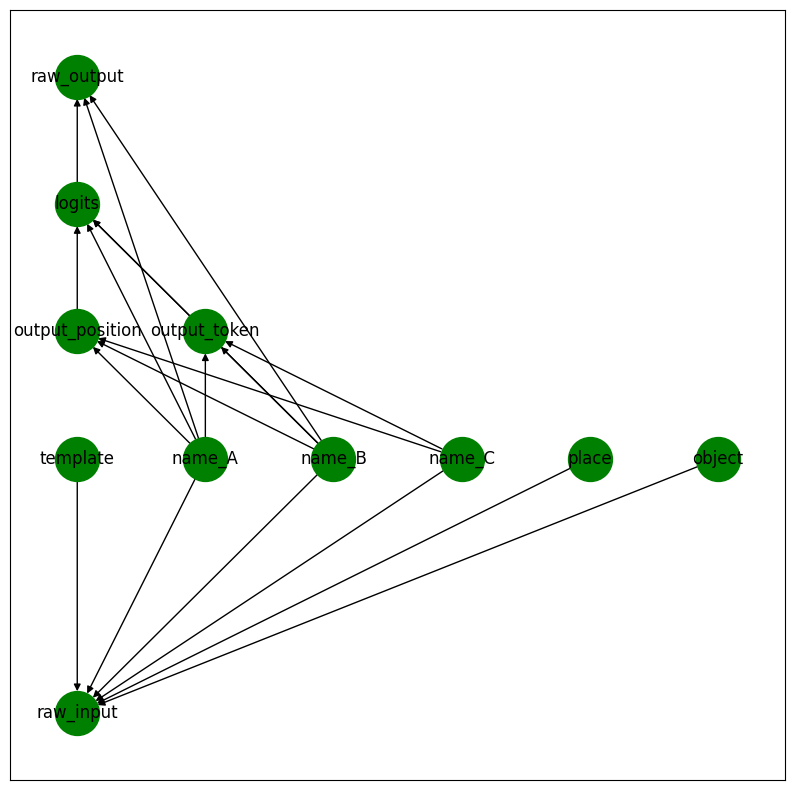

In [2]:
# Create the causal model with default parameters
causal_model = create_ioi_causal_model()

# Print the structure
print_structure(causal_model)

## Sample and Run an Input

In [3]:
# Sample a well-formed input
example = sample_well_formed_input()

print("Input variables:")
print(f"name_A: {example['name_A']}")
print(f"name_B: {example['name_B']}")
print(f"name_C: {example['name_C']}")
print(f"place: {example['place']}")
print(f"object: {example['object']}")
print(f"\nPrompt:\n{example['raw_input']}")

Input variables:
name_A: Christopher
name_B: Kevin
name_C: Kevin
place: restaurant
object: ring

Prompt:
As Christopher and Kevin left the restaurant, Kevin gave a ring to


In [4]:
# Run the causal model forward to get all variables
full_setting = causal_model.new_trace(example)

print("\nCausal model outputs:")
print(f"output_position: {full_setting['output_position']} (0=A correct, 1=B correct)")
print(f"output_token: {full_setting['output_token']}")
print(f"logits: {full_setting['logits']}")
print(f"raw_output: {full_setting['raw_output']}")


Causal model outputs:
output_position: 0 (0=A correct, 1=B correct)
output_token: Christopher
logits: {'Christopher': 4.0, 'Kevin': 2.0}
raw_output: {'string': ' Christopher', 'logits': {'Christopher': 4.0, 'Kevin': 2.0}}


## Interchange Interventions on the Causal Model

Interchange interventions fix a variable to the value it would have in a counterfactual input.

In [5]:
# Generate counterfactual datasets
from causalab.causal.counterfactual_dataset import CounterfactualDataset

size = 128

# Create datasets using CounterfactualDataset.from_sampler
datasets = {
    "swap_names": CounterfactualDataset.from_sampler(size, swap_names, id="swap_names"),
    "flip_name_C": CounterfactualDataset.from_sampler(
        size, flip_name_C, id="flip_name_C"
    ),
    "flip_name_C_sample_new_IO": CounterfactualDataset.from_sampler(
        size, flip_name_C_sample_new_IO, id="flip_name_C_sample_new_IO"
    ),
    "swap_names_and_flip_C": CounterfactualDataset.from_sampler(
        size, swap_names_and_flip_C, id="swap_names_and_flip_C"
    ),
    "random_counterfactual": CounterfactualDataset.from_sampler(
        size, random_counterfactual, id="random_counterfactual"
    ),
    "random_ABC": CounterfactualDataset.from_sampler(size, random_ABC, id="random_ABC"),
}

print(f"Generated {len(datasets)} datasets with {size} examples each")
print(f"Dataset names: {list(datasets.keys())}")

# Look at the flip_name_C dataset
flip_C_dataset = datasets["flip_name_C"].dataset
print(f"\nFlip name_C dataset has {len(flip_C_dataset)} examples")

# Show one example from the dataset
example_pair = flip_C_dataset[0]
original = example_pair["input"]
counterfactual = example_pair["counterfactual_inputs"][0]

print("\nExample from flip_name_C dataset:")
print(
    f"Original: name_A={original['name_A']}, name_B={original['name_B']}, name_C={original['name_C']}"
)
print(f"  Prompt: {original['raw_input'][:80]}...")
print(f"  Output: {causal_model.new_trace(original)['raw_output']}")

print(
    f"\nCounterfactual: name_A={counterfactual['name_A']}, name_B={counterfactual['name_B']}, name_C={counterfactual['name_C']}"
)
print(f"  Prompt: {counterfactual['raw_input'][:80]}...")
print(f"  Output: {causal_model.new_trace(counterfactual)['raw_output']}")

Generated 6 datasets with 128 examples each
Dataset names: ['swap_names', 'flip_name_C', 'flip_name_C_sample_new_IO', 'swap_names_and_flip_C', 'random_counterfactual', 'random_ABC']

Flip name_C dataset has 128 examples

Example from flip_name_C dataset:
Original: name_A=Crystal, name_B=Erica, name_C=Erica
  Prompt: Before Crystal and Erica left the house, Erica decided to give an ring to...
  Output: {'string': ' Crystal', 'logits': {'Crystal': 4.0, 'Erica': 2.0}}

Counterfactual: name_A=Crystal, name_B=Erica, name_C=Crystal
  Prompt: Before Crystal and Erica left the house, Crystal decided to give an ring to...
  Output: {'string': ' Erica', 'logits': {'Crystal': 2.0, 'Erica': 4.0}}


## Load GPT-2 Small and Test Performance

In [ ]:
from causalab.neural.pipeline import LMPipeline
from transformers import GPT2Config
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "openai-community/gpt2"

# Load GPT2 config
gpt_config = GPT2Config.from_pretrained(model_path)

# Create pipeline with position_ids=True
pipeline = LMPipeline(
    model_path,
    max_new_tokens=1,
    device=device,
    max_length=128,
    config=gpt_config,
    position_ids=True,
)


def checker(neural_output, causal_output):
    """Check if the model output matches the causal model prediction."""
    predicted_token = causal_output["string"].strip()
    return (
        predicted_token in neural_output["string"]
        or neural_output["string"] in predicted_token
    )


print(f"Model loaded on device: {device}")

## Filter Datasets Based on Model Performance

In [7]:
from causalab.experiments.filter_experiment import FilterExperiment

# Filter datasets to only keep examples the model gets correct
print("Filtering datasets based on GPT-2 performance...")
filter_exp = FilterExperiment(pipeline, causal_model, checker)

# Add random_ABC back to datasets (it was not filtered)
datasets_for_filtering = {k: v for k, v in datasets.items() if k != "random_ABC"}

filtered_datasets = filter_exp.filter(
    datasets_for_filtering, verbose=True, batch_size=64
)

# Add random_ABC back without filtering
filtered_datasets["random_ABC"] = datasets["random_ABC"]

print("\nFiltered datasets:")
for name, dataset in filtered_datasets.items():
    print(f"  {name}: {len(dataset)} examples")

Filtering datasets based on GPT-2 performance...


Filtering swap_names: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Dataset 'swap_names': kept 78/128 examples (60.9%)


Filtering flip_name_C: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Dataset 'flip_name_C': kept 88/128 examples (68.8%)


Filtering flip_name_C_sample_new_IO: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Dataset 'flip_name_C_sample_new_IO': kept 84/128 examples (65.6%)


Filtering swap_names_and_flip_C: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Dataset 'swap_names_and_flip_C': kept 95/128 examples (74.2%)


Filtering random_counterfactual: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

Dataset 'random_counterfactual': kept 86/128 examples (67.2%)

Total filtering results:
Original examples: 640
Kept examples: 431
Overall keep rate: 67.3%

Filtered datasets:
  swap_names: 78 examples
  flip_name_C: 88 examples
  flip_name_C_sample_new_IO: 84 examples
  swap_names_and_flip_C: 95 examples
  random_counterfactual: 86 examples
  random_ABC: 128 examples


In [8]:
# ============================================================================
# Attention Head Patching with New API
# ============================================================================

from causalab.experiments.LM_experiments.attention_head_experiment import PatchAttentionHeads
from causalab.neural.token_position_builder import TokenPosition, get_last_token_index

config = {
    "id": "ioi_attention_heads_demo",
    "top_k_logits": 100,
    "batch_size": 64,
}

results_dir = "tasks/IOI/results/demo/"
num_heads = pipeline.get_num_attention_heads()
num_layers = pipeline.get_num_layers()

# Create token position for last token
last_token = TokenPosition(
    lambda x: get_last_token_index(x, pipeline), pipeline, id="last_token"
)

# Create list of all attention heads (test each individually)
each_head = [
    [(layer, head)] for layer in range(0, num_layers) for head in range(num_heads)
]

experiment = PatchAttentionHeads(pipeline, each_head, last_token, config=config)

print("Running attention head patching...")
raw_results = experiment.perform_interventions(
    {"random_ABC": filtered_datasets["random_ABC"]},
    verbose=True,
    include_actual_outputs=True,  # ✅ Include actual outputs for logit difference metric
)

print("✅ Raw interventions completed!")

Running attention head patching...


Running interventions: 100%|██████████| 144/144 [02:10<00:00,  1.11it/s, dataset=random_ABC, units=[[AtomicModelUnit(id='AttentionHead(Layer-11,Head-11,Token-last_token)')]]]

✅ Raw interventions completed!


Computing logit difference scores...
Creating logit difference heatmap...


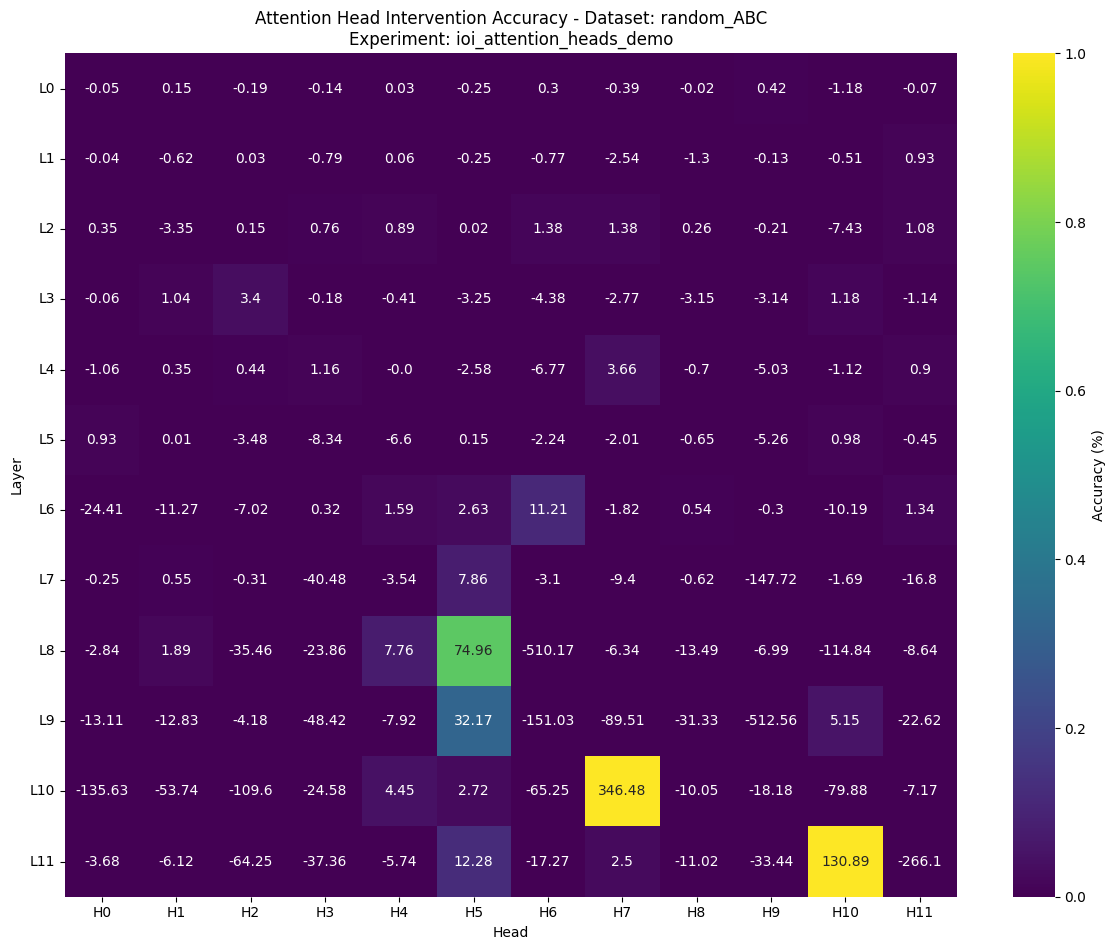

✅ Heatmaps generated!


In [9]:
# ============================================================================
# Logit Difference Visualization with Custom Metric
# ============================================================================

from causalab.experiments.experiment_utils import compute_custom_scores


def ioi_logit_difference_metric(causal_model_input, raw_output, actual_output=None):
    """
    Custom metric that computes logit difference between intervention and actual outputs.

    Uses the causal model to determine the correct token instead of reimplementing IOI logic.

    Updated to work with top-K formatted scores.

    Args:
        causal_model_input: Dict with 'base_input' and 'counterfactual_inputs'
        raw_output: Intervention output (with attention head patched)
        actual_output: Actual output (no intervention) - passed as kwarg

    Returns:
        float: logit_diff[intervention] - logit_diff[actual]
    """
    if actual_output is None:
        raise ValueError("actual_output is required for logit difference metric")

    # Use causal model to determine correct output token
    base_input = causal_model_input['base_input']
    causal_output = causal_model.new_trace(base_input)
    correct_token_text = causal_output['raw_output']['string']

    # Find incorrect token (the other name)
    incorrect_token_text = None
    for token_text in list(causal_output["raw_output"]["logits"].keys()):
        if token_text.strip() == correct_token_text.strip():
            continue
        else:
            incorrect_token_text = token_text
            break

    if incorrect_token_text is None:
        return 0.0

    # Get token IDs
    correct_token_id = pipeline.tokenizer.encode(
        correct_token_text, add_special_tokens=False
    )[0]
    incorrect_token_id = pipeline.tokenizer.encode(
        incorrect_token_text, add_special_tokens=False
    )[0]

    # Helper function to extract logit for a token from top-K formatted scores
    def get_logit_for_token(output_dict, token_id):
        """Extract logit for token_id from top-K formatted scores."""
        # scores format: list of dicts with top_k_logits, top_k_indices, top_k_tokens
        last_position_scores = output_dict["scores"][-1]  # Last token position

        # New top-K format
        top_k_indices = last_position_scores["top_k_indices"][0]  # First batch item
        top_k_logits = last_position_scores["top_k_logits"][0]  # First batch item

        # Find token_id in top-K indices
        for k_idx, idx in enumerate(top_k_indices):
            if idx.item() == token_id:
                return top_k_logits[k_idx].item()

        # Token not in top-K, return very low logit
        return -100.0

    # Extract logits from both intervention and actual outputs
    correct_logit_intervention = get_logit_for_token(raw_output, correct_token_id)
    incorrect_logit_intervention = get_logit_for_token(raw_output, incorrect_token_id)
    diff_intervention = correct_logit_intervention - incorrect_logit_intervention

    correct_logit_actual = get_logit_for_token(actual_output, correct_token_id)
    incorrect_logit_actual = get_logit_for_token(actual_output, incorrect_token_id)
    diff_actual = correct_logit_actual - incorrect_logit_actual

    # Return the difference in logit differences
    return diff_intervention - diff_actual


print("Computing logit difference scores...")
results = compute_custom_scores(
    raw_results,
    custom_scoring_fn=ioi_logit_difference_metric,
    metric_name="logit_difference",
    use_actual_outputs=True,
)

print("Creating logit difference heatmap...")
experiment.plot_heatmaps(
    results,
    ["logit_difference"],
    save_path=results_dir + "logit_difference_heatmaps/",
    average_counterfactuals=False,
)

print("✅ Heatmaps generated!")

## Name-Mover Heads

Use Desiderata-Based Masking (DBM) to learn which attention heads carry the output_token variable.

In [10]:
# ============================================================================
# DBM Training to Find Name-Mover Heads (New API)
# ============================================================================

from causalab.causal.causal_utils import compute_interchange_scores

config = {
    "id": "ioi_dbm_name_mover_demo",  # ✅ Required
    "learning_rate": 0.001,
    "batch_size": 32,
    "evaluation_batch_size": 64,
    "training_epoch": 24,
    "masking": {
        "regularization_coefficient": 0.1,
    },
    "featurizer_kwargs": {"tie_masks": True},
}

# Create list of all attention heads (as one unit for DBM)
all_heads = [
    [(layer, head) for layer in range(0, num_layers) for head in range(num_heads)]
]

experiment = PatchAttentionHeads(pipeline, all_heads, last_token, config=config)

print("Labeling dataset with target variables...")
labeled_data = causal_model.label_counterfactual_data(
    filtered_datasets["random_counterfactual"],
    target_variables=["raw_output"],  # Track output_token variable
)
print("✓ Dataset labeled")

print("\nTraining DBM to localize output_token variable...")
experiment.train_interventions(
    labeled_dataset=labeled_data, method="DBM", verbose=True, checker=checker
)

# Evaluate: run interventions
print("\nEvaluating on training data...")
raw_results = experiment.perform_interventions(
    {"random_counterfactual": filtered_datasets["random_counterfactual"]},
    include_actual_outputs=True,
    verbose=True,
)

# NEW API: Compute scores separately
results = compute_interchange_scores(
    raw_results=raw_results,
    causal_model=causal_model,
    datasets={"random_counterfactual": filtered_datasets["random_counterfactual"]},
    target_variables_list=[["raw_output"]],
    checker=checker,
)

print("✅ Training and evaluation complete!")

Labeling dataset with target variables...
✓ Dataset labeled

Training DBM to localize output_token variable...


Trained intervention for [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-las
Final metrics: loss: 2.4788 accuracy: 0.9640 token_accuracy: 0.9640

Evaluating on training data...


Running interventions: 100%|██████████| 1/1 [00:19<00:00, 19.29s/it, dataset=random_counterfactual, units=[[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-3,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-4,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-5,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-6,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-7,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-8,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-9,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-10,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-11,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-1,Head-0,T

✅ Training and evaluation complete!



Train Performance (IIA): 0.965

Plotting attention head mask heatmap...


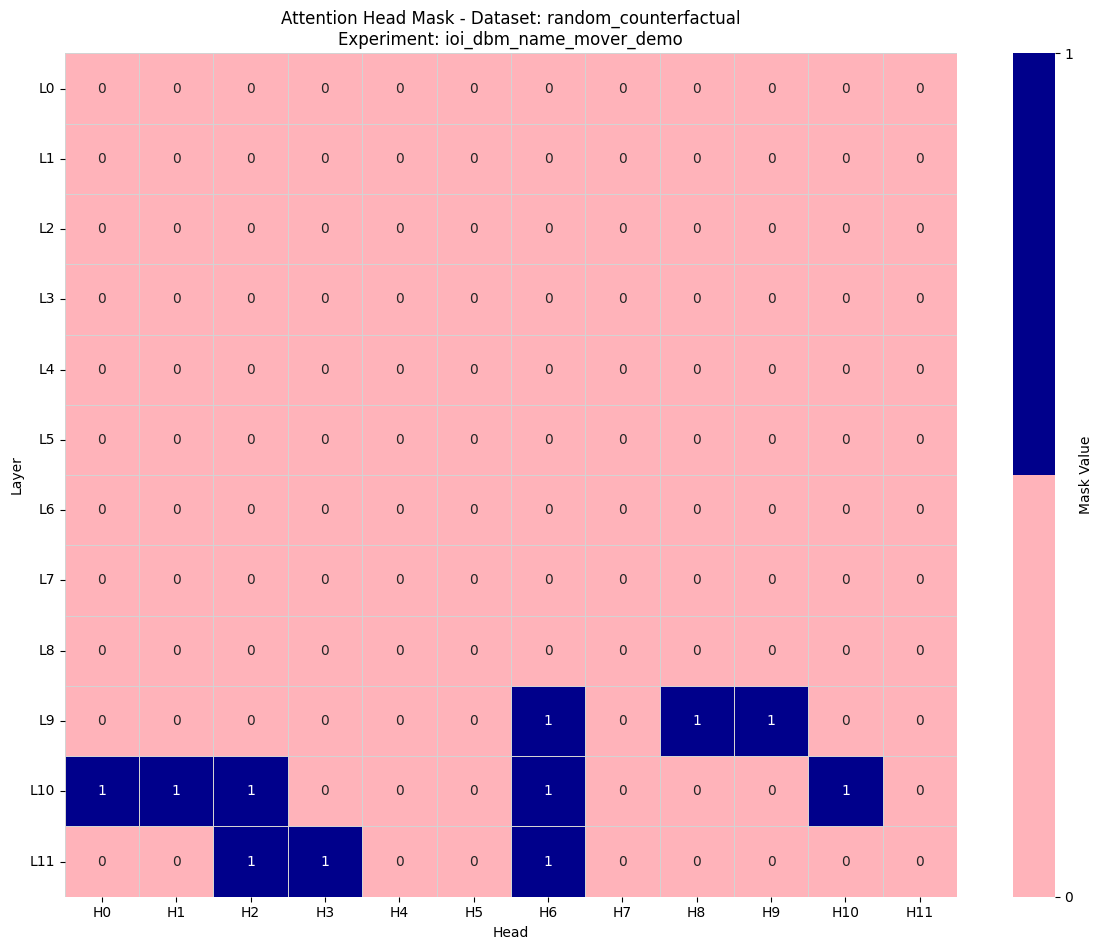

In [11]:
train_score = list(results["dataset"]["random_counterfactual"]["model_unit"].values())[
    0
]["raw_output"]["average_score"]
print(f"\nTrain Performance (IIA): {train_score:.3f}")

# Plot the mask heatmap
print("\nPlotting attention head mask heatmap...")
experiment.plot_mask_heatmap(results, save_path=results_dir)

# Negative Name Mover Heads

In [12]:
example = filtered_datasets["flip_name_C_sample_new_IO"][0]
print("Original Input:")
print(example["input"]["raw_input"])
print("Counterfactual Input:")
print(example["counterfactual_inputs"][0]["raw_input"])
causal_model.can_distinguish_with_dataset(
    filtered_datasets["flip_name_C_sample_new_IO"],
    ["output_position", "output_token"],
    ["raw_output"],
)

Original Input:
Then, Sarah and Brian went to the restaurant. Brian gave a computer to
Counterfactual Input:
Then, Sarah and Melissa went to the restaurant. Sarah gave a computer to
Can distinguish between ['output_position', 'output_token'] and ['raw_output']: 84 out of 84 examples
Proportion of distinguishable examples: 1.00


{'proportion': 1.0, 'count': 84}

In [13]:
# ============================================================================
# Negative Name Mover Heads (New API)
# ============================================================================

config = {
    "id": "ioi_dbm_negative_name_mover_demo",
    "learning_rate": 0.001,
    "batch_size": 32,
    "evaluation_batch_size": 64,
    "training_epoch": 12,
    "masking": {
        "regularization_coefficient": 0.1,
    },
    "featurizer_kwargs": {"tie_masks": True},
}

# Create list of all attention heads
all_heads = [
    [(layer, head) for layer in range(0, num_layers) for head in range(num_heads)]
]

experiment = PatchAttentionHeads(pipeline, all_heads, last_token, config=config)

print("Labeling dataset with target variables ['output_position', 'output_token']...")
labeled_data = causal_model.label_counterfactual_data(
    filtered_datasets["flip_name_C_sample_new_IO"],
    target_variables=["output_position", "output_token"],  # Track both variables
)
print("✓ Dataset labeled")

print("\nTraining DBM to localize heads carrying both variables...")
experiment.train_interventions(
    labeled_dataset=labeled_data,  # ✅ Pass labeled data
    method="DBM",
    verbose=True,
    checker=checker,  # ✅ Checker now passed here
)

# Evaluate: run interventions
print("\nEvaluating on training data...")
raw_results = experiment.perform_interventions(
    {"flip_name_C_sample_new_IO": filtered_datasets["flip_name_C_sample_new_IO"]},
    verbose=True,
)

results = compute_interchange_scores(
    raw_results=raw_results,
    causal_model=causal_model,
    datasets={
        "flip_name_C_sample_new_IO": filtered_datasets["flip_name_C_sample_new_IO"]
    },
    target_variables_list=[["output_position", "output_token"]],
    checker=checker,
)

print("✅ Training and evaluation complete!")

Labeling dataset with target variables ['output_position', 'output_token']...
✓ Dataset labeled

Training DBM to localize heads carrying both variables...


Trained intervention for [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-las
Final metrics: loss: 1.5344 accuracy: 1.0000 token_accuracy: 1.0000

Evaluating on training data...


Running interventions: 100%|██████████| 1/1 [00:20<00:00, 20.91s/it, dataset=flip_name_C_sample_new_IO, units=[[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-3,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-4,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-5,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-6,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-7,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-8,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-9,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-10,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-11,Token-last_token)'), AtomicModelUnit(id='AttentionHead(Layer-1,Head

✅ Training and evaluation complete!



Train Performance (IIA): 1.000

Plotting attention head mask heatmap...


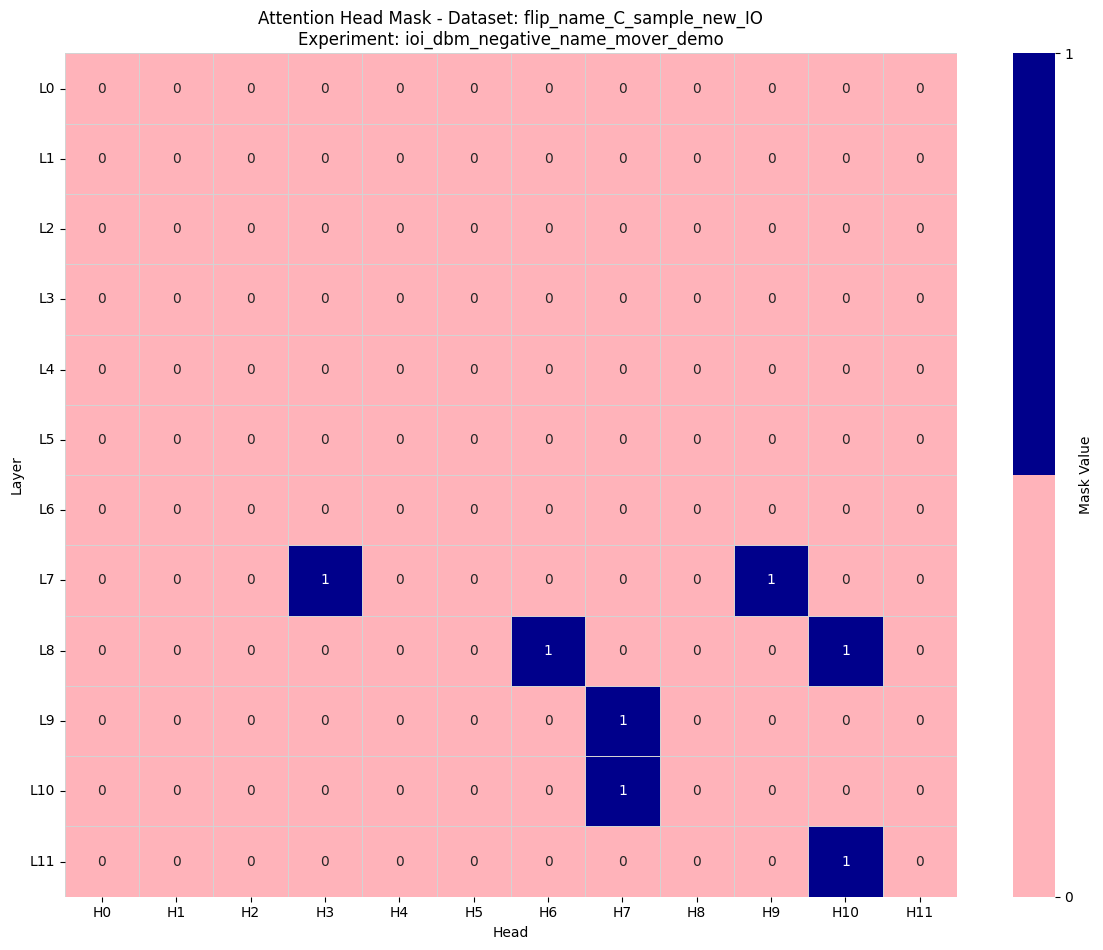

In [14]:
# Print performance
train_score = list(
    results["dataset"]["flip_name_C_sample_new_IO"]["model_unit"].values()
)[0]["output_position-output_token"]["average_score"]
print(f"\nTrain Performance (IIA): {train_score:.3f}")

# Plot the mask heatmap
print("\nPlotting attention head mask heatmap...")
experiment.plot_mask_heatmap(results, save_path=results_dir)